cars: 8792, not-cars: 8968


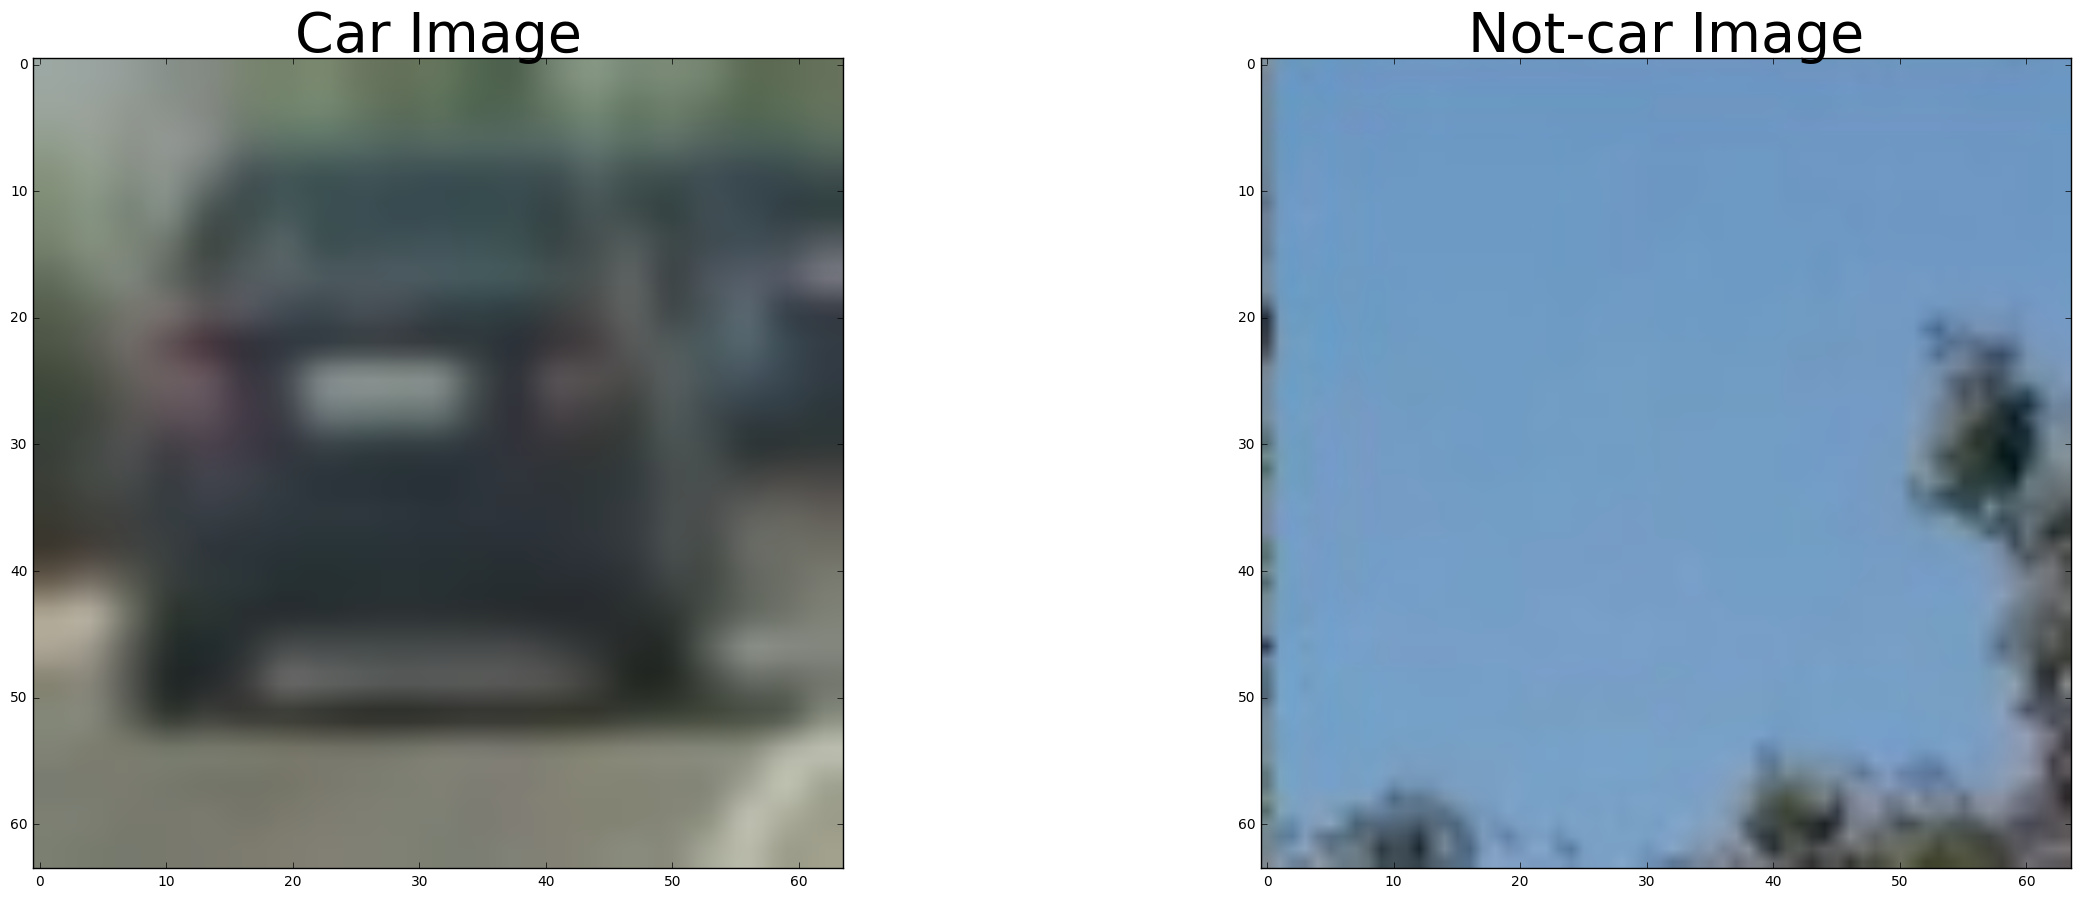

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

%matplotlib inline

class ImagePlot:
    def __init__(self, image, title="", cmap="jet"):
        self.image = image
        self.title = title
        self.cmap = cmap
        
    def plot(self, axis):
        axis.imshow(self.image, cmap=self.cmap)
        axis.set_title(self.title, fontsize=40)        

def plot_images(*image_plots):
    num = len(image_plots)
    f, axes = plt.subplots(1, num, figsize=(24, 9))
    f.tight_layout()
    for image, axis in zip(image_plots, axes):
        image.plot(axis)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
                          
def recursive_image_filenames(path, extension='.png'):
    results = []
    for root, subdirs, files in os.walk(path):
        for filename in files: 
            if filename.endswith(extension):
                results.append(os.path.join(root, filename))
    return results

# Get list of training images
cars = recursive_image_filenames('training/vehicles')
notcars = recursive_image_filenames('training/non-vehicles')

print('cars: {}, not-cars: {}'.format(len(cars), len(notcars)))

car_img = mpimg.imread(cars[0])
notcar_img = mpimg.imread(notcars[0])
plot_images(
    ImagePlot(car_img, title='Car Image'), 
    ImagePlot(notcar_img, title='Not-car Image')
)


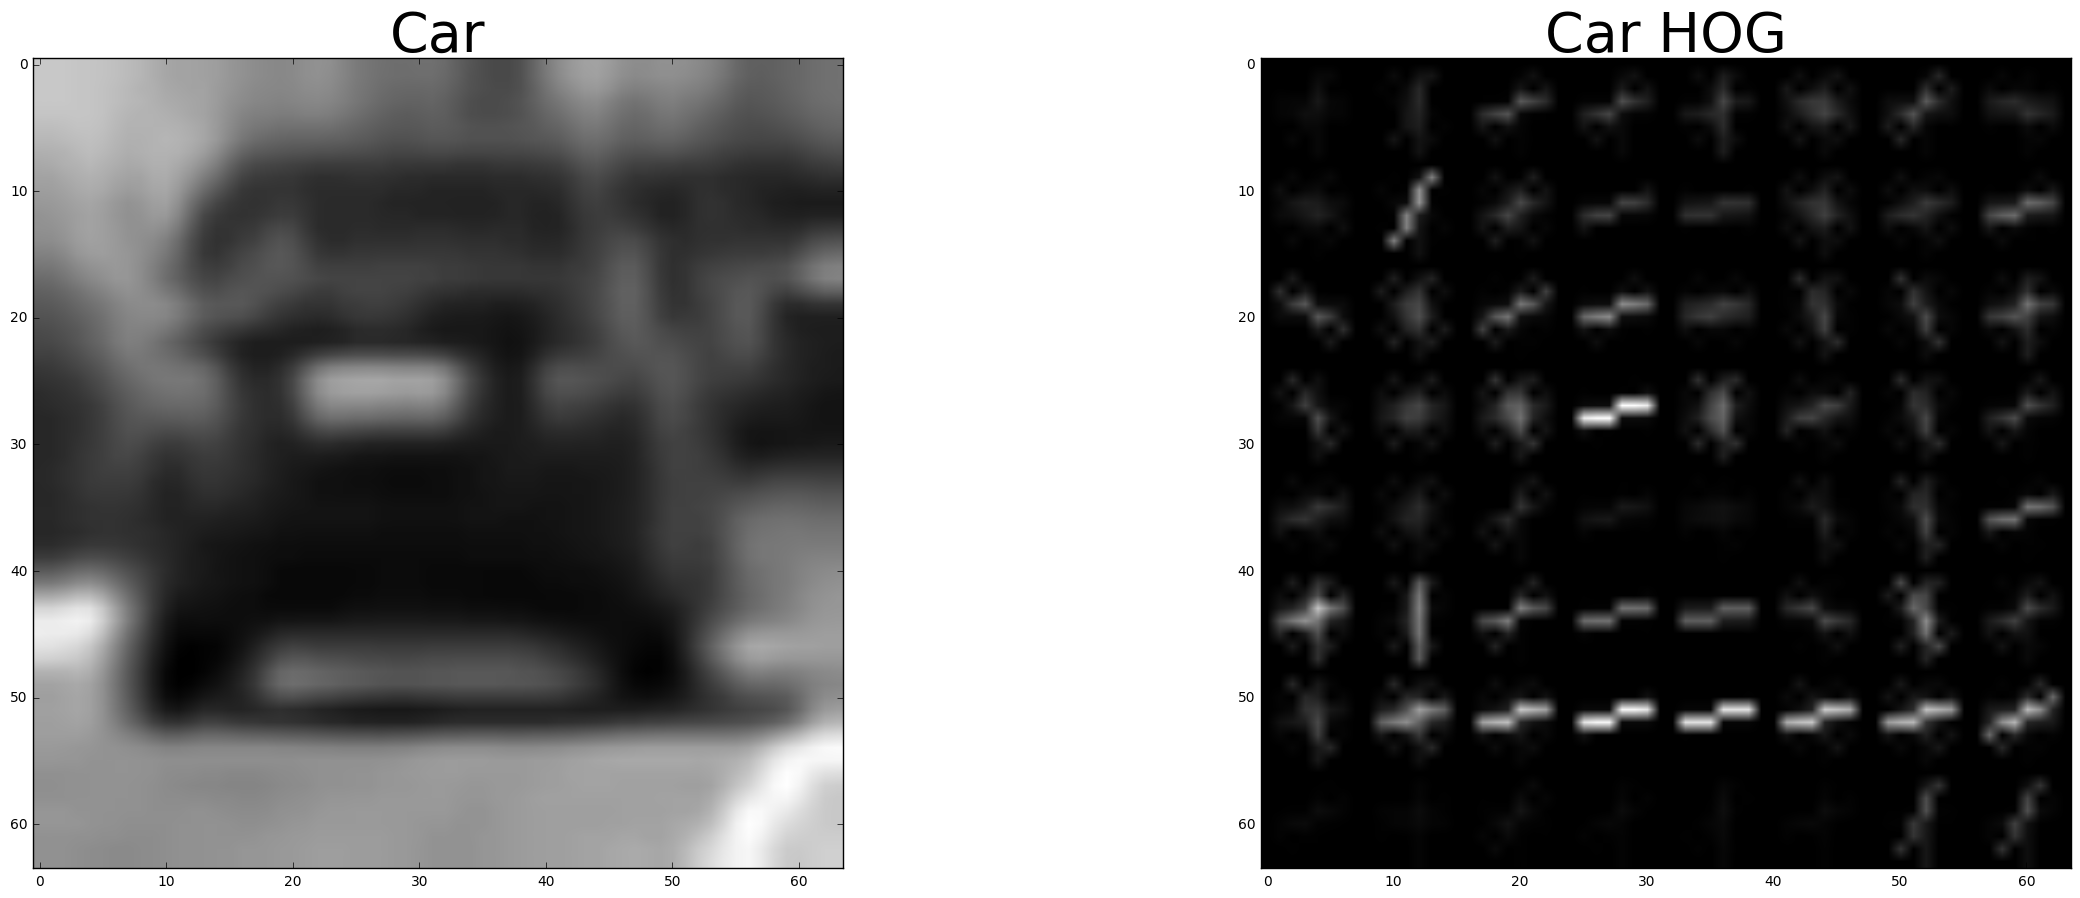

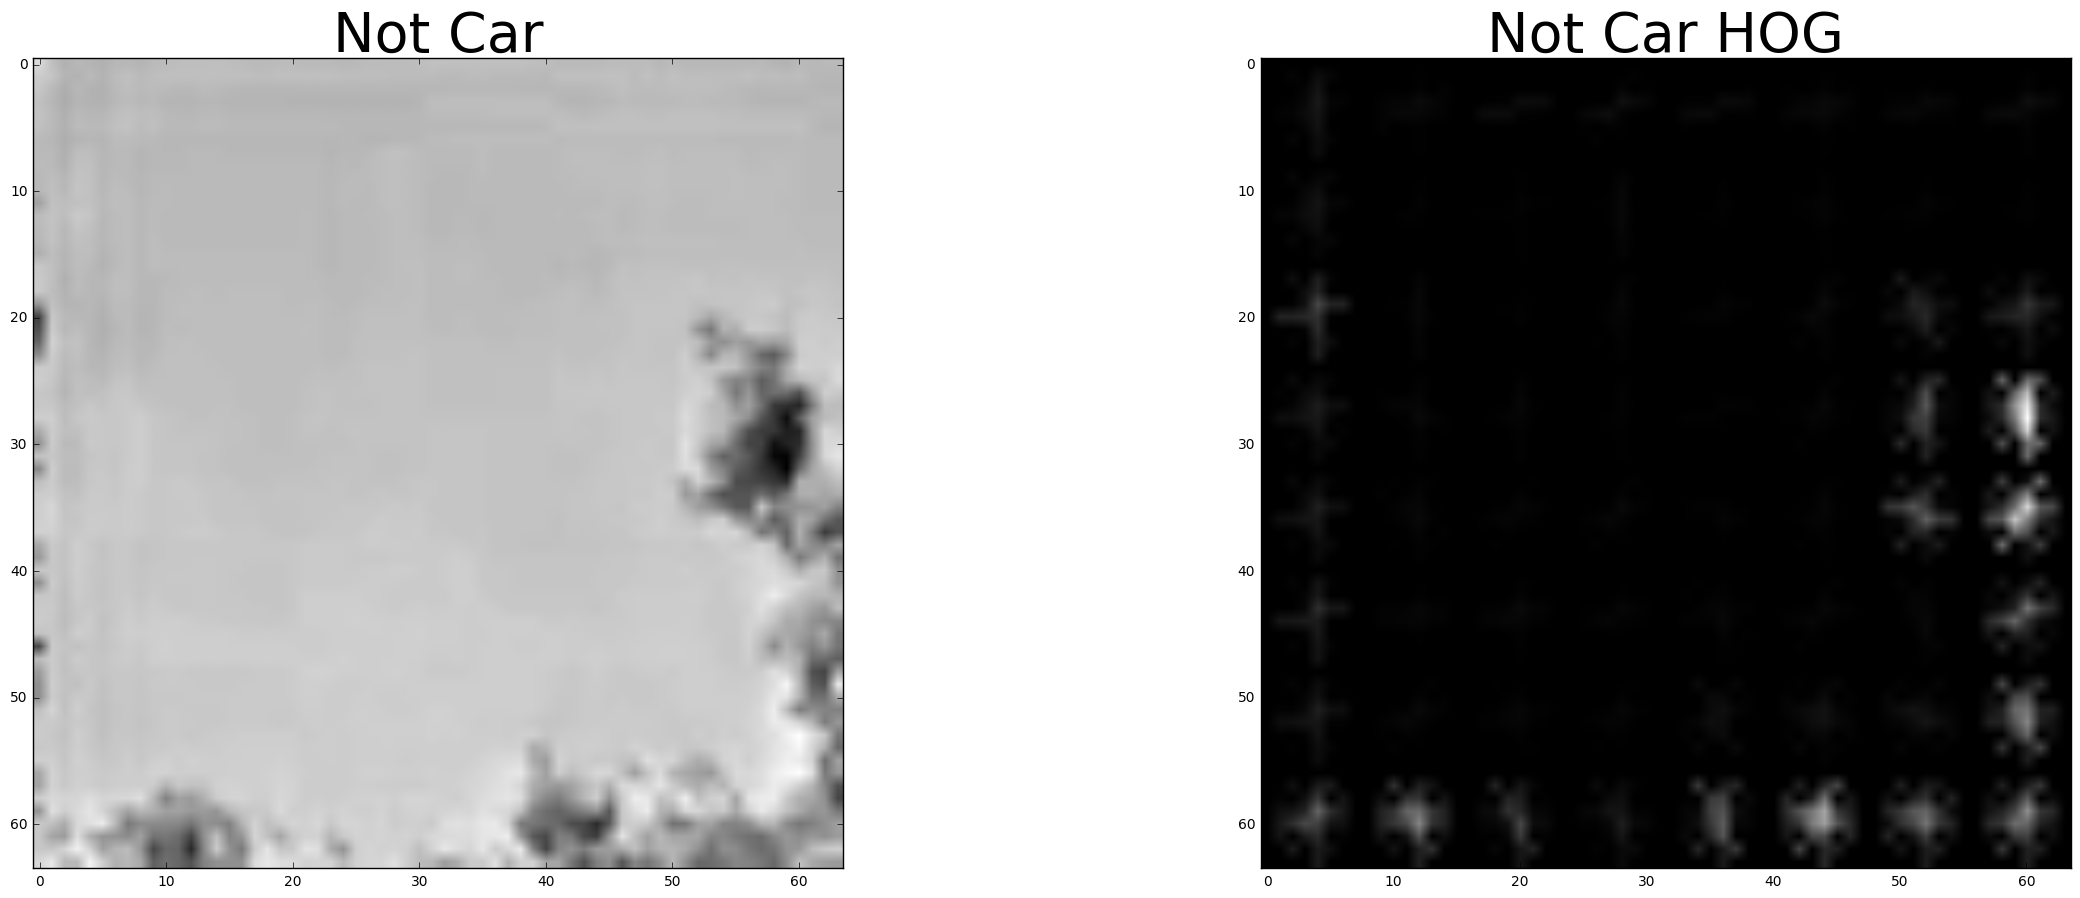

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def convert_color(image, cspace='RGB'):
    conversions = {
        'HSV': cv2.COLOR_RGB2HSV,
        'LUV': cv2.COLOR_RGB2LUV,
        'HLS': cv2.COLOR_RGB2HLS,
        'YUV': cv2.COLOR_RGB2YUV,
        'YCrCb': cv2.COLOR_RGB2YCrCb,
    }
    
    conversion = conversions[cspace]
    if conversion is not None:
        return cv2.cvtColor(image, conversion)
    else: return image

### Feature extraction parameters
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL" (for best results)

# Sample hog image visualtions
car_img_ch0 = car_img[:,:,0]
features, hog_image = get_hog_features(car_img_ch0, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plot_images(
    ImagePlot(car_img_ch0, title='Car', cmap="gray"), 
    ImagePlot(hog_image, title='Car HOG', cmap="gray")
)

notcar_img_ch0 = notcar_img[:,:,0]
features, hog_image = get_hog_features(notcar_img_ch0, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plot_images(
    ImagePlot(notcar_img_ch0, title='Not Car', cmap="gray"), 
    ImagePlot(hog_image, title='Not Car HOG', cmap="gray")
)


In [3]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, cspace=cspace)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

print("Extract features...")
t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))    


Extract features...
75.93 Seconds to extract features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
23.5 Seconds to train SVC...
Test Accuracy of SVC =  0.9941


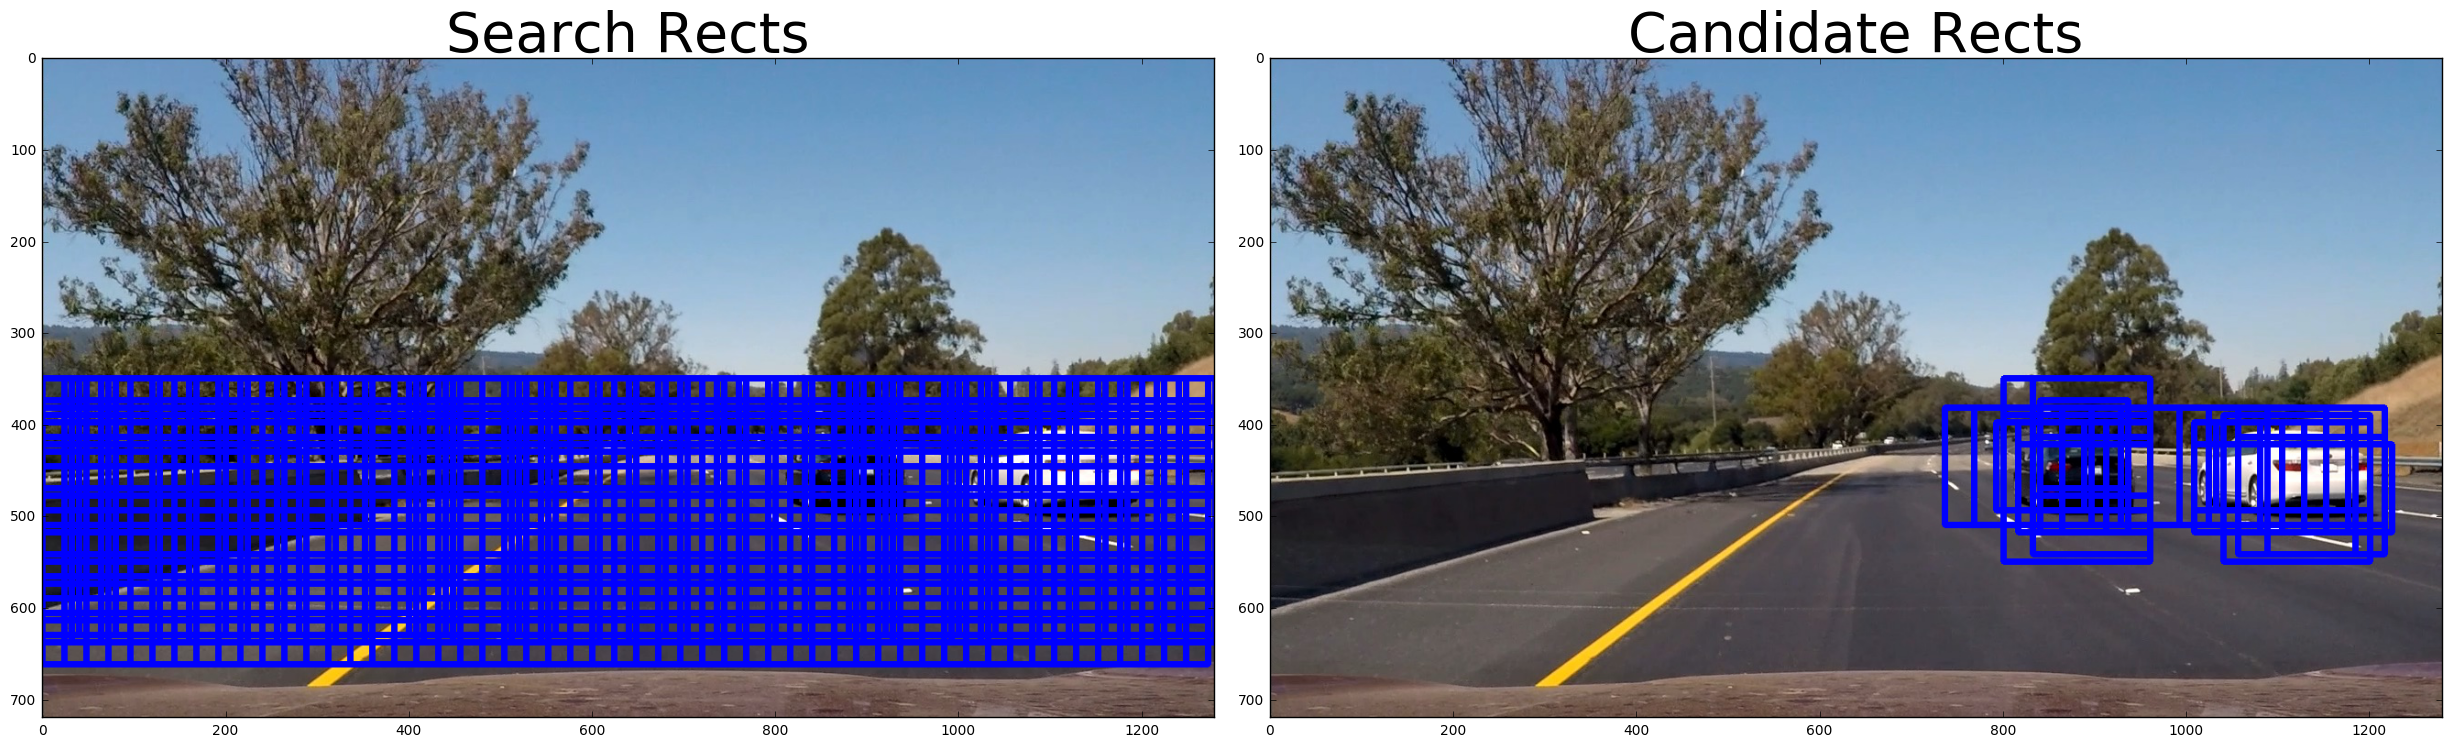

In [4]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_candidates(img, cspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, debug=False):
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace=cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)
    nyblocks = (ch1.shape[0] // pix_per_cell)
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rects = []
    search_rects = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            # Current window rectangle
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            p1 = (xbox_left, ytop_draw+ystart)
            p2 = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
            rect = (p1, p2)
            
            if debug:
                search_rects.append(rect)

            if test_prediction == 1:
                rects.append(rect)

    return rects, search_rects

def draw_rectangles(img, rects):
    draw_img = np.copy(img)
    for p1, p2 in rects:
        cv2.rectangle(draw_img, p1, p2, (0,0,255), 6)
    return draw_img

def find_candidates_at_scales(img, scales, debug=False):
    # Parameters for find_cars
    ystart = 350
    ystop = 675
    spatial_size = (32, 32)
    hist_bins = 32

    rects = []
    search_rects = []
    for scale in scales:
        results, search = find_candidates(img, colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, debug=debug)
        rects.extend(results)
        search_rects.extend(search)
        
    return rects, search_rects

test_img = mpimg.imread('test_images/test6.jpg')

# Generate
rects, search_rects = find_candidates_at_scales(test_img, [1.5, 2, 2.5], debug=True)
search_img = draw_rectangles(test_img, search_rects)

rects, _ = find_candidates_at_scales(test_img, [1.5, 2, 2.5])
out_img = draw_rectangles(test_img, rects)

plot_images(
    ImagePlot(search_img, title='Search Rects'), 
    ImagePlot(out_img, title='Candidate Rects')
)

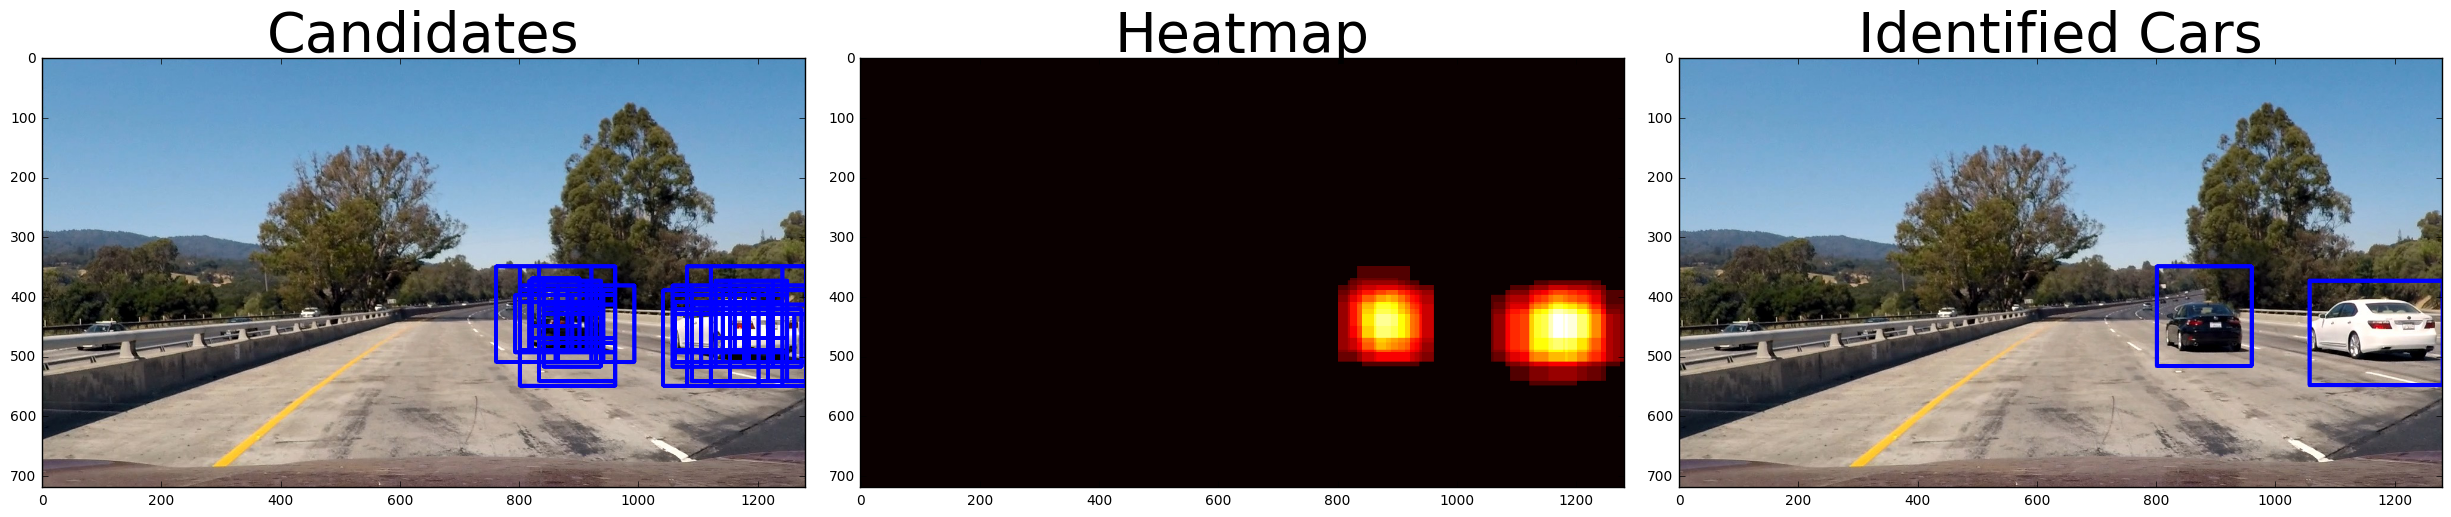

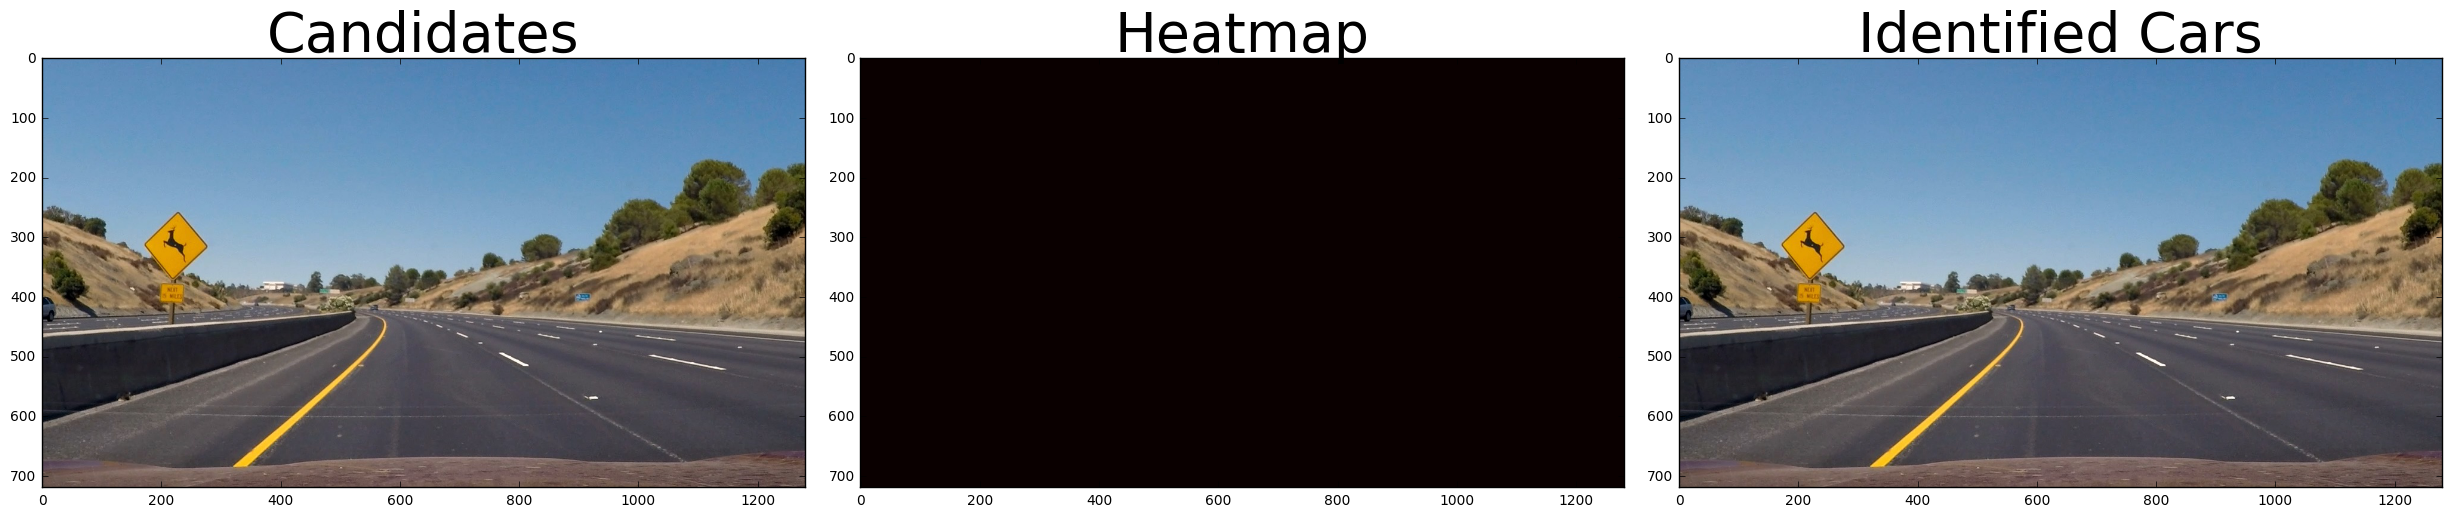

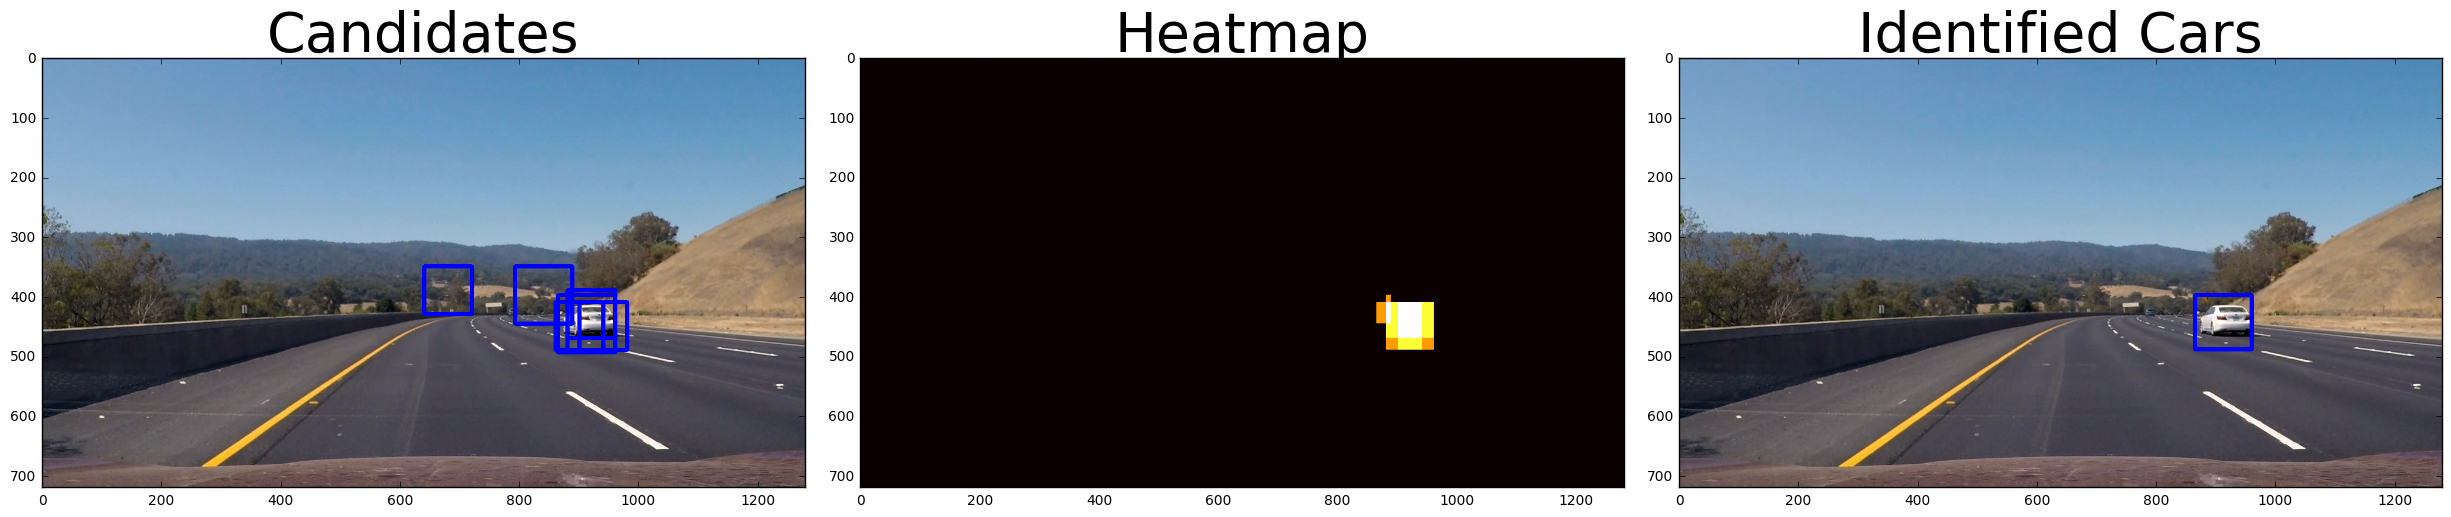

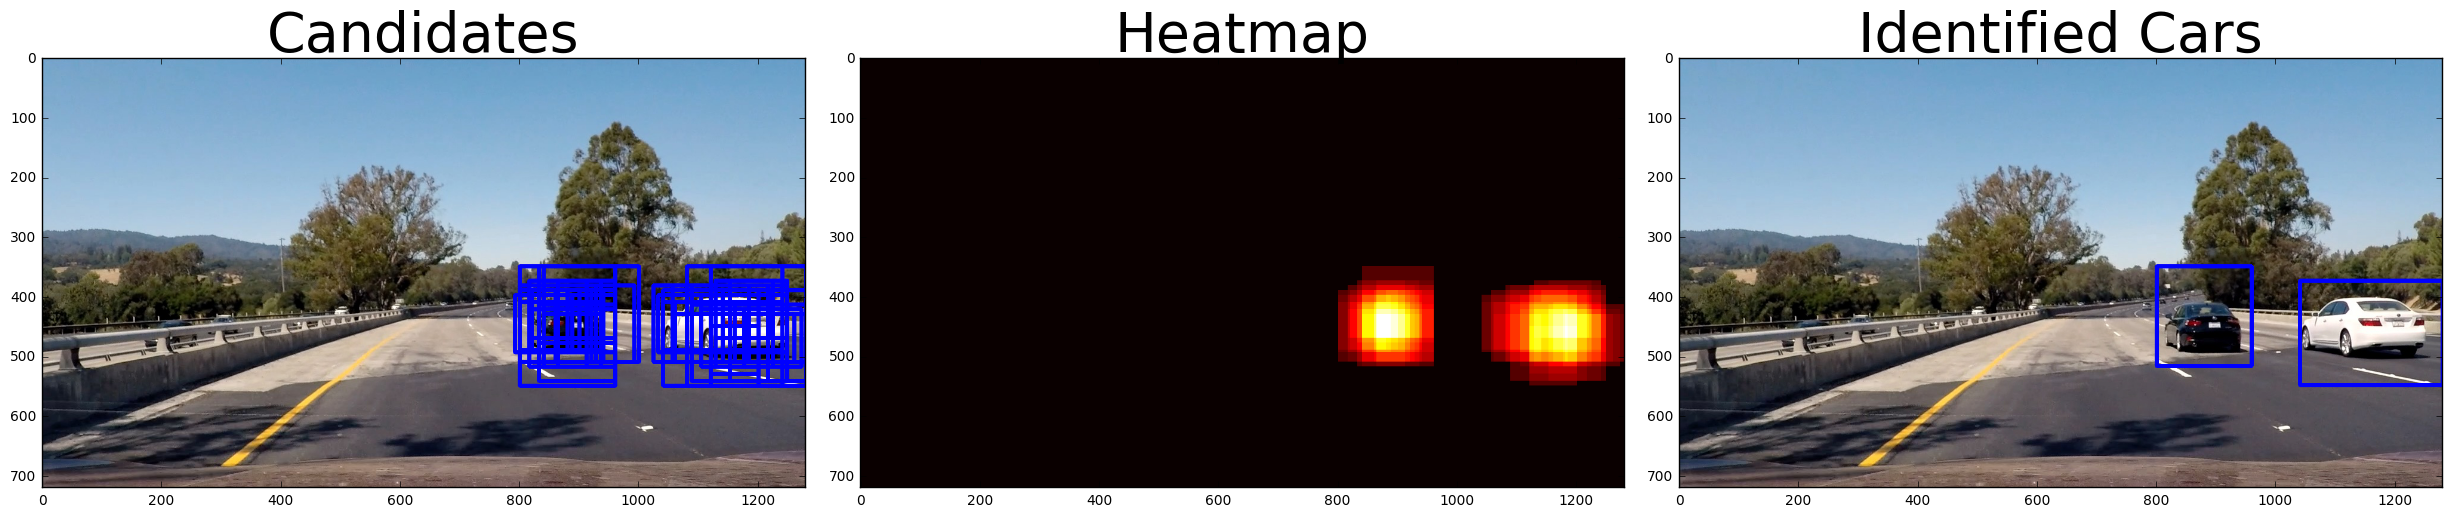

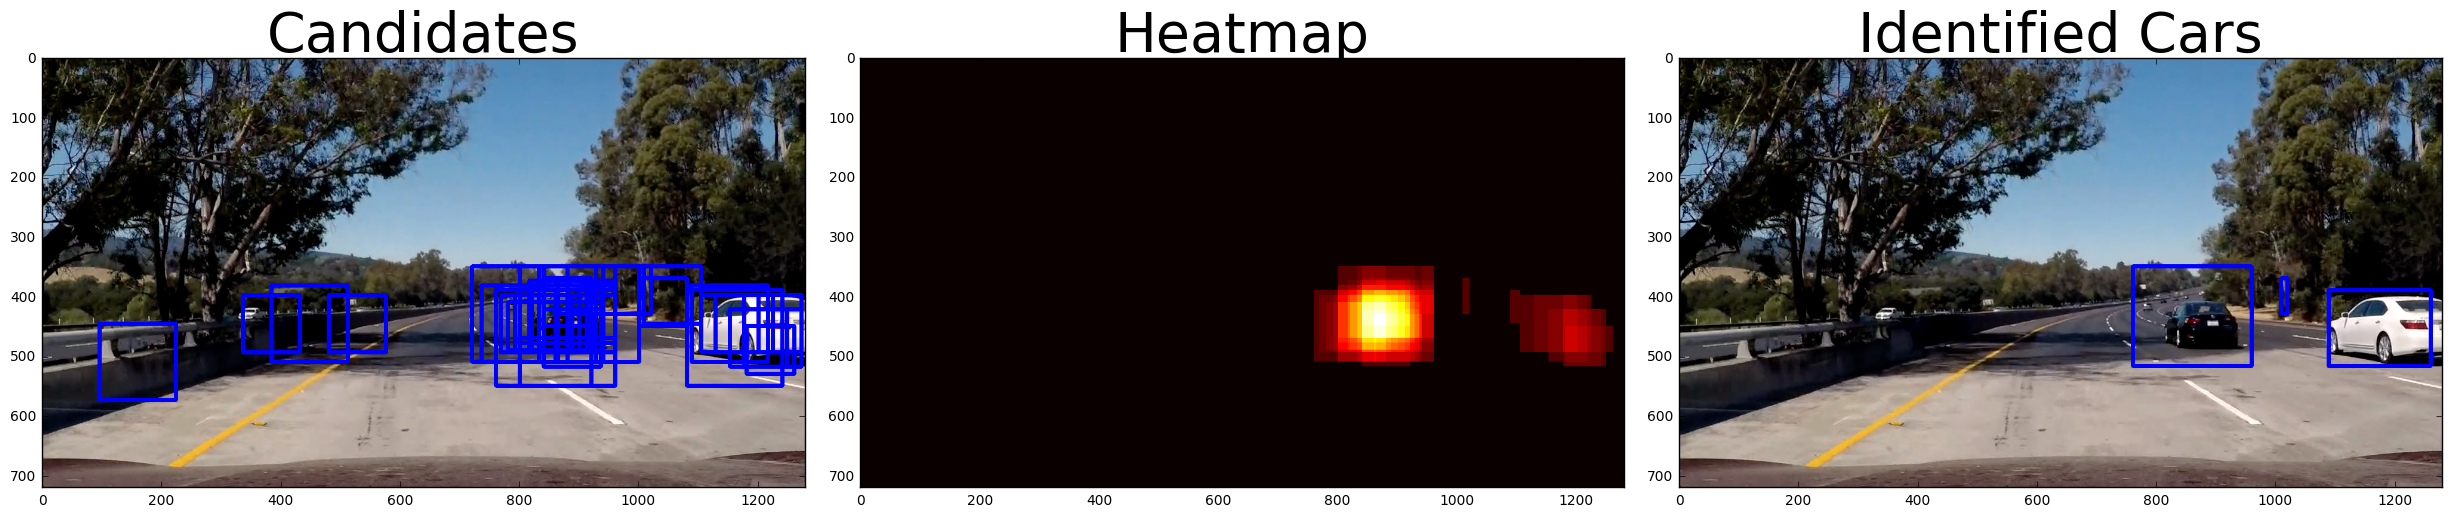

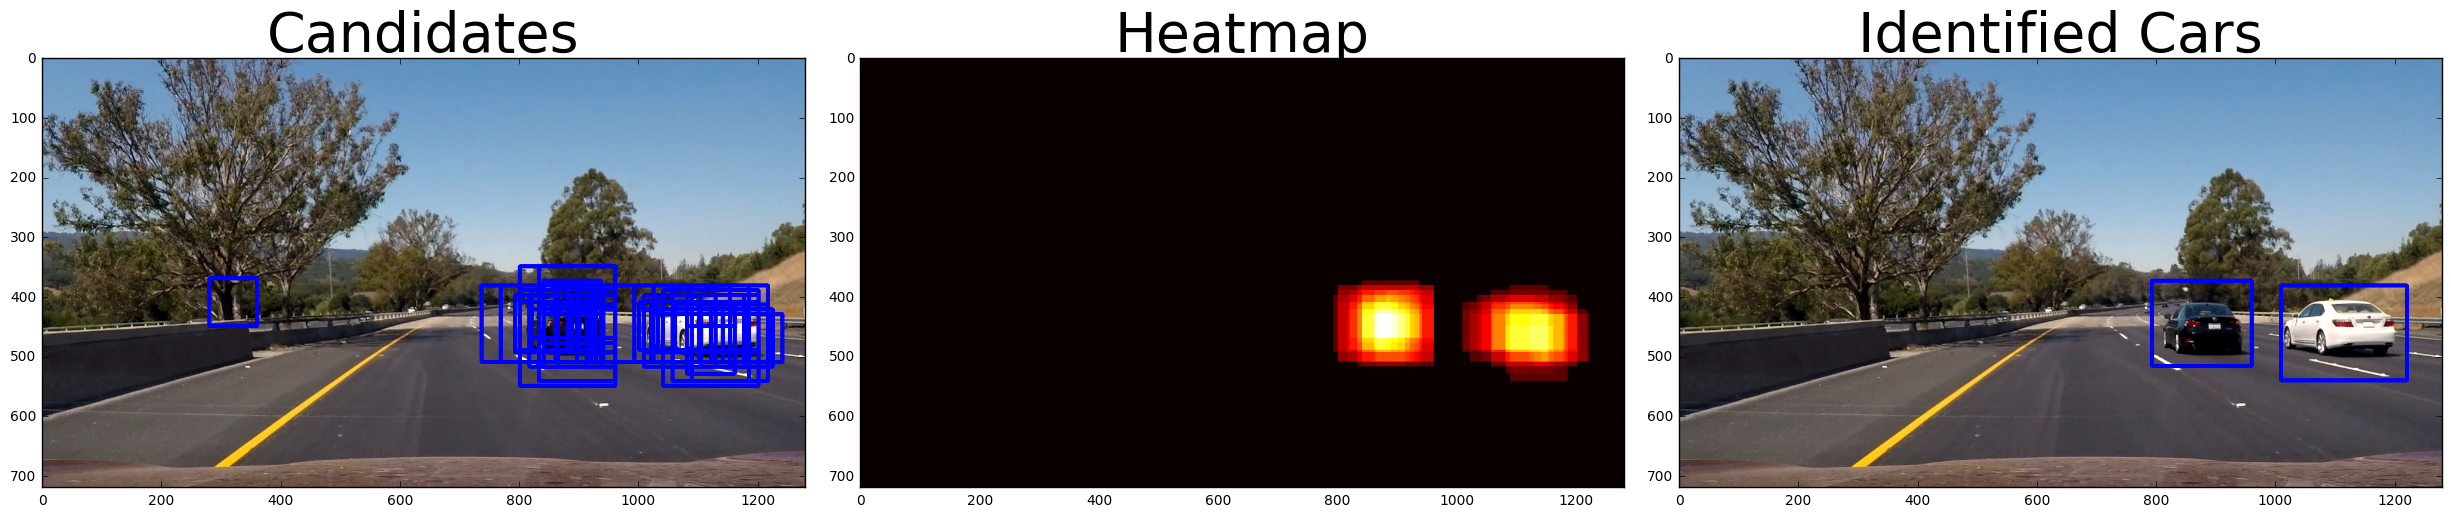

In [6]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def identify_cars(img, debug=False):
    # Find potential cars
    rects, _ = find_candidates_at_scales(img, [1.25, 1.5, 2, 2.5])
    # Create heat array
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, rects)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    result_img = draw_labeled_bboxes(np.copy(img), labels)
    if debug:
        debug_img = draw_rectangles(img, rects)
        plot_images(
            ImagePlot(debug_img, title='Candidates'), 
            ImagePlot(heatmap, title='Heatmap', cmap='hot'),
            ImagePlot(result_img, title='Identified Cars'),
        )
    return result_img

# All test images
for image_file in glob.glob('test_images/*.jpg'):
    test_img = mpimg.imread(image_file)
    identify_cars(test_img, debug=True)

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_file = 'output.mp4'
input_video = VideoFileClip('project_video.mp4')
output_video = input_video.fl_image(identify_cars)
%time output_video.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [28:47<00:01,  1.38s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 27min 58s, sys: 1min 1s, total: 28min 59s
Wall time: 28min 47s
